# Field data processing and inversion
This notebook will feature the different processing and filtering functions of the `EMagPy` Python API. The data were collected using a CMD Mini-Explorer on agricultural field sown with different crops in 2022 at Gaiarine, province of Treviso (IT).

**Author:** Alberto Carrera

In [1]:
from emagpy import Problem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import EMIutils as utils

indir = '../data/'
outdir = '../data/output/'
figdir = '../figures/'

# FDEM data comes from 3 different survey dates
fnames = ['gaia-2022-02-03', # time-zero
          'gaia-2022-03-02', # t1
          'gaia-2022-04-14'] # t2

fname = fnames[0]
fname

'gaia-2022-02-03'

## Importing data
After specifying the directory, data can be imported and displayed.

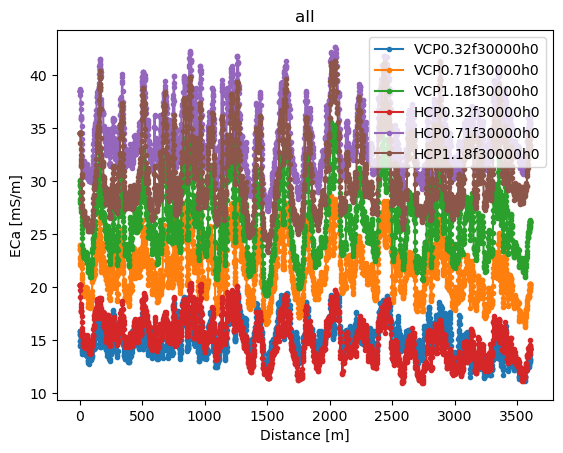

In [2]:
# create an instance for multicoil FDEM survey
k = Problem() 
k.createSurvey(indir + fname + '.csv')
k.show()

The data has already been processed.  
We can now evaluate the depth sensitivity of the survey, considering the ECa values collected

(-1.7, 0.07125000000000001)

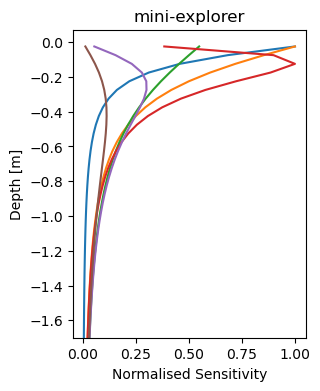

In [3]:
#compute the sensitivity
k.setInit(depths0=np.arange(0.05, 2, 0.05))
k.depths = k.depths0.copy() # need to specify initial model to compute sensitivity
k.models = k.conds0.copy()
sens = k.computeSens()
depth = k.depths[0][0,:]
mdepths = np.r_[depth[0]/2, depth[:-1] + np.diff(depth)/2, depth[-1]]

fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(sens[0][:,:,0], -mdepths)
ax.set_xlabel('Normalised Sensitivity')
ax.set_ylabel('Depth [m]')
ax.set_title('mini-explorer')
ax.set_ylim(-1.7)
#fig.savefig(outputdir + fname + '-sens.png', dpi=300)

we can clearly see how, in this site and for this specific survey, the investigation depth is limited to the first meter below the surface.  
Pay attention to this, since manufacturers' depth ranges are often overestimated: 0.5 / 0.25 m, 1.0 / 0.5 m, 1.8 / 0.9 m (VCP/HCP)

## Inversion
We will perform a smooth inversion to look at the general distribution of EC with depths.  
For this, we must specify an array of depths to be fixed in the initial model.  


In [4]:
# parametrization
depths = np.arange(0.1, 1.5, 0.1)
conds0 = np.ones(depths.shape[0]+1)*25
#conds0[0] = 10 # initial EC (mS/m)
k.setInit(depths0=depths, conds0=conds0) # depth bottom of layer in meters

depths

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4])

We also need to introduce smoothing into the model using an alpha value, coming from the L-curve analysis.

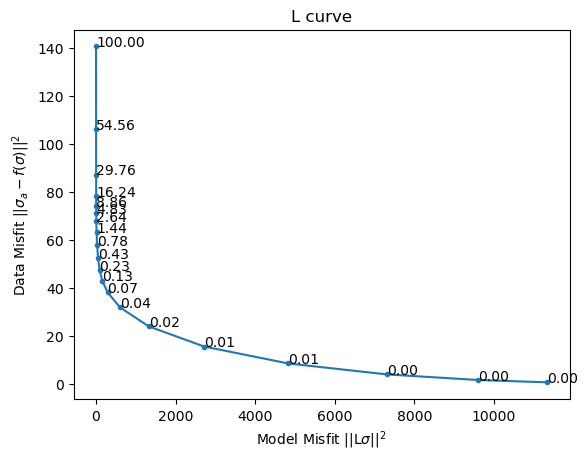

In [5]:
k.lcurve()

In [6]:
# multicoil inversion
k.invert(forwardModel='CSgn', alpha=0.04, regularization='l2'
         #forwardModel='FSlin', method='Gauss-Newton', regularization='l2', alpha=0.04
        ) # alpha > 0.1 will cause vertical smoothing

Survey 1/1
2767/2767 inverted


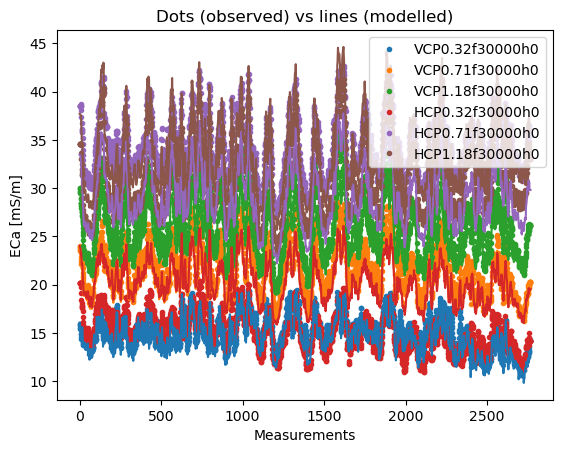

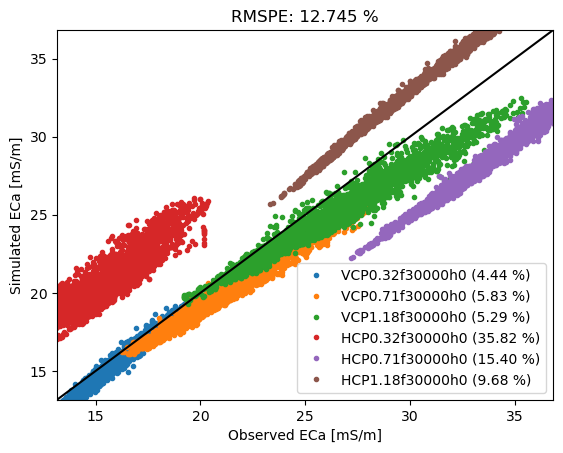

In [7]:
# plot
k.showMisfit()
k.showOne2one()

## Save and Plot
We now save the inversion results and load the output file to inspect it

In [8]:
# save results
k.saveInvData(outdir +'inv/')

df = pd.read_csv(outdir + 'inv/inv_' + fname + '.csv', sep=',')
df.head()

,x,y,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8,...,depth5,depth6,depth7,depth8,depth9,depth10,depth11,depth12,depth13,depth14
0,771344.863633,5.084651e+06,6.119853,9.250407,18.690740,28.424717,35.905841,40.904876,43.897590,45.428651,...,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4
1,771344.864533,5.084651e+06,6.095786,9.234838,18.670100,28.397244,35.874381,40.872623,43.867014,45.401439,...,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4
2,771344.820033,5.084651e+06,5.993885,9.195354,18.665386,28.406620,35.887945,40.885952,43.878192,45.409689,...,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4
3,771344.732333,5.084651e+06,5.714957,9.069326,18.597672,28.349677,35.829161,40.824936,43.817714,45.352723,...,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4
4,771344.563933,5.084651e+06,5.397501,8.945858,18.584012,28.381803,35.875832,40.871812,43.858321,45.384256,...,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4


we can rearrange the output default format in order to have a simple x,y,z,value file with the function

In [9]:
final_df = utils.model_output(df)
final_df.to_csv(outdir + 'inv/' + fname+'INV.csv', index=False)
final_df.head()

,x,y,depth,EC
0,771344.863633,5.084651e+06,0.1,6.119853
1,771344.864533,5.084651e+06,0.1,6.095786
2,771344.820033,5.084651e+06,0.1,5.993885
3,771344.732333,5.084651e+06,0.1,5.714957
4,771344.563933,5.084651e+06,0.1,5.397501


we can now plot the areal data at different depths with the basemap:

/home/alberto/Documents/UNIPD/ESERCITAZIONI/GeophysicalMethods/emi/notebooks/EMIutils.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{val:.5f}°" for val in lon], fontsize=10)
/home/alberto/Documents/UNIPD/ESERCITAZIONI/GeophysicalMethods/emi/notebooks/EMIutils.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{val:.5f}°" for val in lat], fontsize=10)
/home/alberto/Documents/UNIPD/ESERCITAZIONI/GeophysicalMethods/emi/notebooks/EMIutils.py:160: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{val:.5f}°" for val in lon], fontsize=10)
/home/alberto/Documents/UNIPD/ESERCITAZIONI/GeophysicalMethods/emi/notebooks/EMIutils.py:161: UserWarning: set_ticklabels() should only 

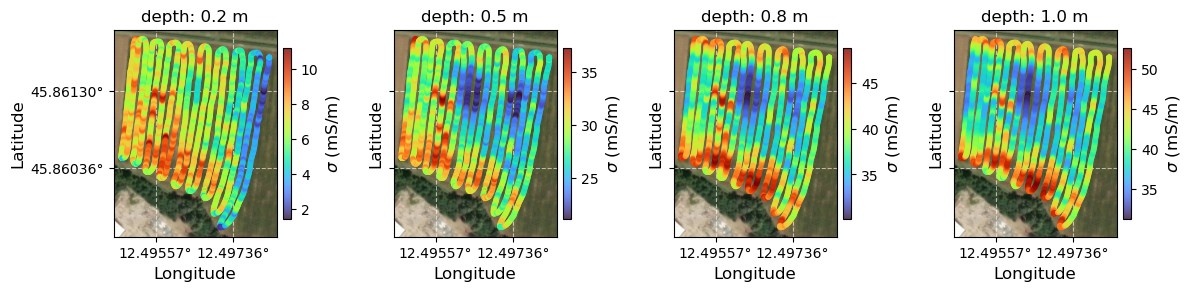

In [10]:
depths_to_plot = [0.2, 0.5, 0.8, 1.0]

# Con basemap
utils.plot_model(final_df, depths_to_plot, basemap=True, utm_crs="EPSG:32632", grid=True)

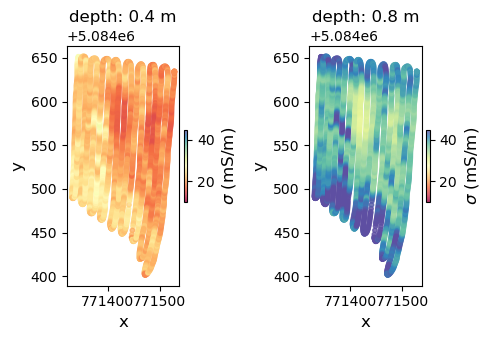

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(5, 3.5))
utils.plot_model(final_df, depths=[0.4, 0.8,],
           basemap=False, cmap='Spectral',
           axs=axs, vmin=10, vmax=45)
plt.tight_layout()
fig.savefig(figdir + fname+'_nomap.jpg', dpi=150)
plt.show()